# Subset Generation

In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from tqdm import tqdm
from pprint import pprint
tqdm.pandas()

## Interpolated Subset (Subset-296)

songdo_traffic_core.dataset.nodelink 모듈을 통해 생성한 데이터를 기반으로 Interpolation 및 subset 생성

In [2]:
from songdo_traffic_core.dataset.interpolator import (
    IterativeRandomForestInterpolator,
    LinearInterpolator,
    SplineInterpolator,
)
from songdo_traffic_core.dataset.metr_imc.generator import MetrImcSubsetGenerator

In [3]:
def extend_nans_around_zeros(series: pd.Series) -> pd.Series:
    series = series.copy()
    nan_indices = series[series.isna()].index

    for idx in nan_indices:
        idx_pos = series.index.get_loc(idx)

        i = idx_pos - 1
        while i >= 0 and series.iat[i] == 0:
            series.iat[i] = np.nan
            i -= 1

        i = idx_pos + 1
        while i < len(series) and series.iat[i] == 0:
            series.iat[i] = np.nan
            i += 1

    return series

In [4]:
df_imc: pd.DataFrame = pd.read_hdf("../datasets/metr-imc/metr-imc.h5")
df_imc

,1680254606,1650051800,1670030907,1610002406,1650374201,1650038700,1690052500,1650054600,1640002100,1660001406,...,1680093100,1610104400,1650230200,1630168900,1640247500,1610120700,1610028300,1650352801,1630026000,1660003900
2023-01-01 00:00:00,0.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,9.0,NaN,...,91.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,409.0
2023-01-01 01:00:00,0.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,25.0,NaN,...,97.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,370.0
2023-01-01 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0.0,NaN,...,54.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,236.0
2023-01-01 03:00:00,0.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0.0,NaN,...,38.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,219.0
2023-01-01 04:00:00,0.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0.0,NaN,...,31.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-06 19:00:00,NaN,149.0,315.0,0.0,6.0,15.0,19.0,99.0,166.0,219.0,...,452.0,NaN,0.0,NaN,NaN,NaN,0.0,129.0,789.0,1182.0
2023-12-06 20:00:00,NaN,99.0,266.0,0.0,0.0,3.0,16.0,50.0,122.0,172.0,...,358.0,NaN,0.0,NaN,NaN,NaN,0.0,86.0,636.0,994.0
2023-12-06 21:00:00,NaN,89.0,230.0,0.0,0.0,0.0,12.0,15.0,125.0,195.0,...,326.0,NaN,0.0,NaN,NaN,NaN,0.0,37.0,517.0,818.0
2023-12-06 22:00:00,NaN,46.0,135.0,0.0,0.0,0.0,10.0,0.0,68.0,148.0,...,233.0,NaN,0.0,NaN,NaN,NaN,0.0,9.0,319.0,617.0


현재는 결측치가 너무 많은 데이터는 제외하고 실험

In [5]:
no_missing_columns = df_imc.columns[df_imc.isnull().sum() == 0].to_list()
less_500_missing_columns = df_imc.columns[df_imc.isnull().sum() < 500].to_list()    # 현재 선택된 대상 그룹    
less_750_missing_columns = df_imc.columns[df_imc.isnull().sum() < 750].to_list()

len(less_500_missing_columns)

296

In [6]:
generator = MetrImcSubsetGenerator(
    nodelink_dir="../datasets/metr-imc/nodelink",
    imcrts_dir="../datasets/metr-imc/imcrts",
    metr_imc_dir="../datasets/metr-imc/",
)

In [7]:
if generator.metr_imc_df is not None:
    print(generator.metr_imc_df.index)
    print("Freq:", pd.infer_freq(generator.metr_imc_df.index))
    generator.metr_imc_df.iloc[:, :7]
else:
    print("Warning: metr_imc_df is None")

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='h')
Freq: h


결측치 주변의 값이 대부분 0으로 되어 있다. 결측치가 발생하고 측정이 재개되었을 때, 시간이 걸리고 0으로 측정된다는 가설하에 결측치 주변의 0은 모두 결측치로 처리하였다.

In [8]:
generator.metr_imc_df = generator.metr_imc_df.apply(extend_nans_around_zeros)

# Mac에서 대략 30초 소요

Interpolation 방법은 여러가지가 있을 수 있으며 현재는 아래와 같은 Interpolation으로 정의

In [9]:
interpolator = SplineInterpolator()

### Interpolation 완료한 Subset 생성

In [10]:
SUBSET_296_TARGET_DIR = "../datasets/metr-imc/subsets/metr-imc-296-int"

In [11]:
# generator.generate_subset(less_500_missing_columns, SUBSET_296_TARGET_DIR, interpolator)

In [12]:
# pd.read_hdf("../datasets/metr-imc/subsets/metr-imc-296-int/metr-imc.h5").to_excel(
#     "../datasets/metr-imc/subsets/metr-imc-296-int/metr-imc-296-int.xlsx"
# )

생성된 데이터를 Shapefile로 시각화

In [13]:
# from songdo_traffic_core.dataset.metr_imc.converter.graph_sensor_locations import SensorNetworkView

# SUBSET_TARGET_DISTANCE_FILE_PATH = os.path.join(SUBSET_296_TARGET_DIR, "distances_imc_2023.csv")
# SUBSET_TARGET_SENSOR_FILE_PATH = os.path.join(SUBSET_296_TARGET_DIR, "graph_sensor_locations.csv")
# SUBSET_TARGET_NETWORK_DIR = os.path.join(SUBSET_296_TARGET_DIR, "miscellaneous")

# SensorNetworkView(SUBSET_TARGET_DISTANCE_FILE_PATH, SUBSET_TARGET_SENSOR_FILE_PATH).to_file(SUBSET_TARGET_NETWORK_DIR)

## Small Group (Subset-37)

앞에서 선택한 결측치 500개 미만의 데이터 중 임의로 Clustering을 한 37개의 그룹을 추가로 추출하여 작은 그룹을 만들었다. 이 그룹이 적절한 그래프 구조와 적은 결측치를 가지고 있기에 테스트 용도로 적합할 것으로 판단하였다.

아래는 QGIS를 통해서 추출한 Subset 목록의 Shapefile 이다.

In [14]:
SUBSET_37_TARGET_DIR = "../datasets/metr-imc/subsets/metr-imc-37"

subset_37_targets: gpd.GeoDataFrame = gpd.read_file(
    os.path.join(SUBSET_37_TARGET_DIR, "selected_roads.shp")
)
print(subset_37_targets["NODE_ID"].to_list())

[1650026001, 1640014100, 1640014900, 1640049000, 1640012000, 1650044800, 1650024702, 1650044700, 1650029601, 1640015000, 1650388701, 1650386401, 1640014500, 1650026402, 1650024801, 1650380301, 1650041400, 1650034700, 1650039300, 1650015703, 1650384901, 1650001203, 1650041300, 1650381801, 1650391401, 1650389601, 1650378201, 1650025902, 1650034800, 1650028601, 1650221500, 1650001102, 1650026301, 1640015800, 1650039400, 1640015700, 1640011900]


In [15]:
print("Shape:", subset_37_targets.shape)
print("Uniques:")
print(subset_37_targets.nunique())

Shape: (37, 3)
Uniques:
index       37
NODE_ID     37
geometry    37
dtype: int64


In [16]:
target_columns = [str(value) for value in subset_37_targets["NODE_ID"].to_list()]
sub_37_df = generator.metr_imc_df[target_columns]
print("sub_37_df: Shape", sub_37_df.shape)

sub_37_df: Shape (8760, 37)


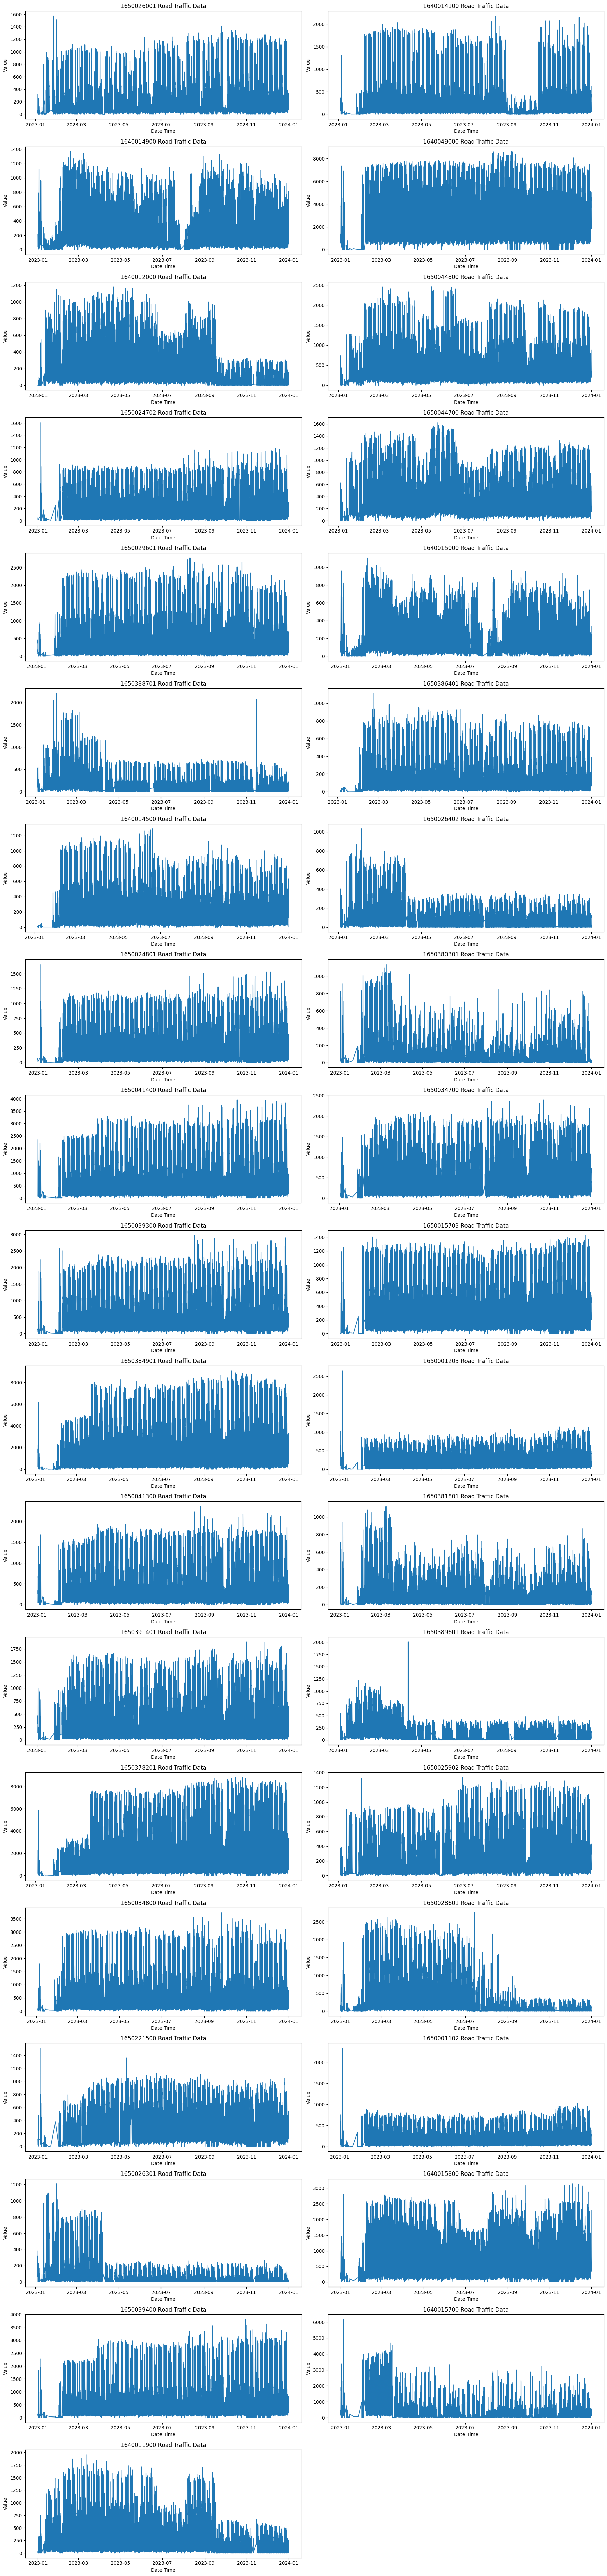

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = len(sub_37_df.columns)
num_graphs_per_row = 2
num_rows = (num_cols + num_graphs_per_row - 1) // num_graphs_per_row

fig, axes = plt.subplots(num_rows, num_graphs_per_row, figsize=(18, 4 * num_rows))

for i, col in enumerate(sub_37_df.columns):
    row = i // num_graphs_per_row
    col_index = i % num_graphs_per_row
    sns.lineplot(ax=axes[row, col_index], data=sub_37_df[col])
    axes[row, col_index].set_title(f"{sub_37_df[col].name} Road Traffic Data")
    axes[row, col_index].set_xlabel("Date Time")
    axes[row, col_index].set_ylabel("Value")

for j in range(i + 1, num_rows * num_graphs_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [18]:
sub_37_df.isna().sum()

1650026001    244
1640014100    507
1640014900    216
1640049000    422
1640012000    206
1650044800    149
1650024702    632
1650044700    149
1650029601    405
1640015000    247
1650388701    525
1650386401    497
1640014500    530
1650026402    385
1650024801    452
1650380301    442
1650041400    407
1650034700    542
1650039300    373
1650015703    570
1650384901    433
1650001203    582
1650041300    400
1650381801    440
1650391401    468
1650389601    508
1650378201    494
1650025902    244
1650034800    419
1650028601    338
1650221500    656
1650001102    583
1650026301    370
1640015800    373
1650039400    380
1640015700    558
1640011900    206
dtype: int64

In [19]:
generator.metr_imc_df.iloc[0].index

Index(['1610001700', '1610001800', '1610001900', '1610002000', '1610002100',
       '1610002200', '1610002302', '1610002304', '1610002306', '1610002307',
       ...
       '1690050900', '1690051000', '1690051300', '1690051400', '1690051500',
       '1690051600', '1690052500', '1690052600', '1690053500', '1690053600'],
      dtype='object', length=2113)

In [20]:
from songdo_traffic_core.dataset.interpolator import TimeMeanFillInterpolator


interpolator = TimeMeanFillInterpolator()
generator.generate_subset(target_columns, SUBSET_37_TARGET_DIR, interpolator)

2024/07/22 17:41:23 songdo_traffic_core.dataset.metr_imc.generator [INFO] Start generating subset...
2024/07/22 17:41:23 songdo_traffic_core.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets/metr-imc-37/metr-imc.h5...
2024/07/22 17:41:23 songdo_traffic_core.dataset.metr_imc.generator [INFO] Interpolating...


1650026001 of 0 hour
1650026001 of 1 hour
1650026001 of 2 hour
1650026001 of 3 hour
1650026001 of 4 hour
1650026001 of 5 hour
1650026001 of 6 hour
1650026001 of 7 hour
1650026001 of 8 hour
1650026001 of 9 hour
1650026001 of 10 hour
1650026001 of 11 hour
1650026001 of 12 hour
1650026001 of 13 hour
1650026001 of 14 hour
1650026001 of 15 hour
1650026001 of 16 hour
1650026001 of 17 hour
1650026001 of 18 hour
1650026001 of 19 hour
1650026001 of 20 hour
1650026001 of 21 hour
1650026001 of 22 hour
1650026001 of 23 hour
1640014100 of 0 hour
1640014100 of 1 hour
1640014100 of 2 hour
1640014100 of 3 hour
1640014100 of 4 hour
1640014100 of 5 hour
1640014100 of 6 hour
1640014100 of 7 hour
1640014100 of 8 hour
1640014100 of 9 hour
1640014100 of 10 hour
1640014100 of 11 hour
1640014100 of 12 hour
1640014100 of 13 hour
1640014100 of 14 hour
1640014100 of 15 hour
1640014100 of 16 hour
1640014100 of 17 hour
1640014100 of 18 hour
1640014100 of 19 hour
1640014100 of 20 hour
1640014100 of 21 hour
16400141

2024/07/22 17:41:24 songdo_traffic_core.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets/metr-imc-37/metr_ids.txt...
2024/07/22 17:41:24 songdo_traffic_core.dataset.metr_imc.converter.metr_ids [INFO] Saving METR-IMC IDs to ../datasets/metr-imc/subsets/metr-imc-37/metr_ids.txt...
2024/07/22 17:41:24 songdo_traffic_core.dataset.metr_imc.converter.metr_ids [INFO] Complete
2024/07/22 17:41:24 songdo_traffic_core.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets/metr-imc-37/graph_sensor_locations.csv...


1650026301 of 8 hour
1650026301 of 9 hour
1650026301 of 10 hour
1650026301 of 11 hour
1650026301 of 12 hour
1650026301 of 13 hour
1650026301 of 14 hour
1650026301 of 15 hour
1650026301 of 16 hour
1650026301 of 17 hour
1650026301 of 18 hour
1650026301 of 19 hour
1650026301 of 20 hour
1650026301 of 21 hour
1650026301 of 22 hour
1650026301 of 23 hour
1640015800 of 0 hour
1640015800 of 1 hour
1640015800 of 2 hour
1640015800 of 3 hour
1640015800 of 4 hour
1640015800 of 5 hour
1640015800 of 6 hour
1640015800 of 7 hour
1640015800 of 8 hour
1640015800 of 9 hour
1640015800 of 10 hour
1640015800 of 11 hour
1640015800 of 12 hour
1640015800 of 13 hour
1640015800 of 14 hour
1640015800 of 15 hour
1640015800 of 16 hour
1640015800 of 17 hour
1640015800 of 18 hour
1640015800 of 19 hour
1640015800 of 20 hour
1640015800 of 21 hour
1640015800 of 22 hour
1640015800 of 23 hour
1650039400 of 0 hour
1650039400 of 1 hour
1650039400 of 2 hour
1650039400 of 3 hour
1650039400 of 4 hour
1650039400 of 5 hour
165003

2024/07/22 17:41:25 songdo_traffic_core.dataset.metr_imc.converter.graph_sensor_locations [INFO] Saving sensor locations to ../datasets/metr-imc/subsets/metr-imc-37/graph_sensor_locations.csv...
2024/07/22 17:41:25 songdo_traffic_core.dataset.metr_imc.converter.graph_sensor_locations [INFO] Complete
2024/07/22 17:41:25 songdo_traffic_core.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets/metr-imc-37/distances_imc_2023.csv...
Adding Edges: 100%|██████████| 16381/16381 [00:00<00:00, 17448.27it/s]
2024/07/22 17:41:27 songdo_traffic_core.dataset.metr_imc.converter.distance_imc [INFO] Nodes: 16381, Edges: 35451
Applying Turn Restrictions: 100%|██████████| 2330/2330 [00:00<00:00, 29383.53it/s]
2024/07/22 17:41:27 songdo_traffic_core.dataset.metr_imc.converter.distance_imc [INFO] Nodes: 16381, Edges: 36039
Generating Distances: 100%|██████████| 37/37 [00:00<00:00, 113.00it/s]
2024/07/22 17:41:28 songdo_traffic_core.dataset.metr_imc.converter.distance_imc [INFO] Saving 

In [21]:
SUBSET_FULL_37_TR_PATH = os.path.join(SUBSET_37_TARGET_DIR, "metr-imc.h5")

pd.read_hdf(SUBSET_FULL_37_TR_PATH).to_excel(
    os.path.join(SUBSET_37_TARGET_DIR, "metr-imc-37.xlsx")
)